In [1]:
import os
import sys
import subprocess

def install_package(package):
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])

# Install core dependencies
install_package("ultralytics")
install_package("roboflow")
install_package("matplotlib")
install_package("opencv-python-headless")
install_package("pandas")
install_package("seaborn") # For nicer EDA plots

# Imports
import cv2
import yaml
import torch
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from ultralytics import YOLO
from roboflow import Roboflow

# Notebook settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_colwidth', None)

# System checks
print(f"Python version: {sys.version.split()[0]}")
print(f"Torch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"GPU Detected: {torch.cuda.get_device_name(0)}")
    DEVICE = 0
else:
    print("No GPU detected. Training will be slow on CPU.")
    DEVICE = 'cpu'

Installing ultralytics...
Installing roboflow...
Installing opencv-python-headless...
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Python version: 3.12.12
Torch version: 2.9.0+cu126
GPU Detected: Tesla T4


In [2]:
class Config:
    # Data
    API_KEY = "ffmoeLYtfHCHknfTSk9o" # Roboflow API Key from your snippet
    WORKSPACE = "imit-h5ows"
    PROJECT = "soil-detection-l0ngo"
    VERSION = 3

    # Training
    MODEL_SIZE = "n" # n, s, m, l, x (nano is fastest, large is most accurate)
    EPOCHS = 50
    BATCH_SIZE = 16
    IMG_SIZE = 640
    OPTIMIZER = 'auto'
    SEED = 42

    # Paths
    ROOT_DIR = os.getcwd()
    DATASET_DIR = os.path.join(ROOT_DIR, "Soil-detection-3") # Folder name based on Roboflow version

def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(Config.SEED)
print("Configuration loaded and random seeds set.")

Configuration loaded and random seeds set.


In [3]:
if not os.path.exists(Config.DATASET_DIR):
    print("Downloading dataset...")
    rf = Roboflow(api_key=Config.API_KEY)
    project = rf.workspace(Config.WORKSPACE).project(Config.PROJECT)
    version = project.version(Config.VERSION)
    dataset = version.download("yolov8")
else:
    print(f"Dataset found at {Config.DATASET_DIR}. Skipping download.")

# Verify critical files
yaml_path = os.path.join(Config.DATASET_DIR, "data.yaml")
if not os.path.exists(yaml_path):
    raise FileNotFoundError(f"data.yaml not found at {yaml_path}. Dataset download may have failed.")

print(f"Dataset ready at: {Config.DATASET_DIR}")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Soil-detection-3 in yolov8:: 100%|██████████| 582/582 [00:00<00:00, 3298.50it/s]


Dataset ready at: /content/Soil-detection-3


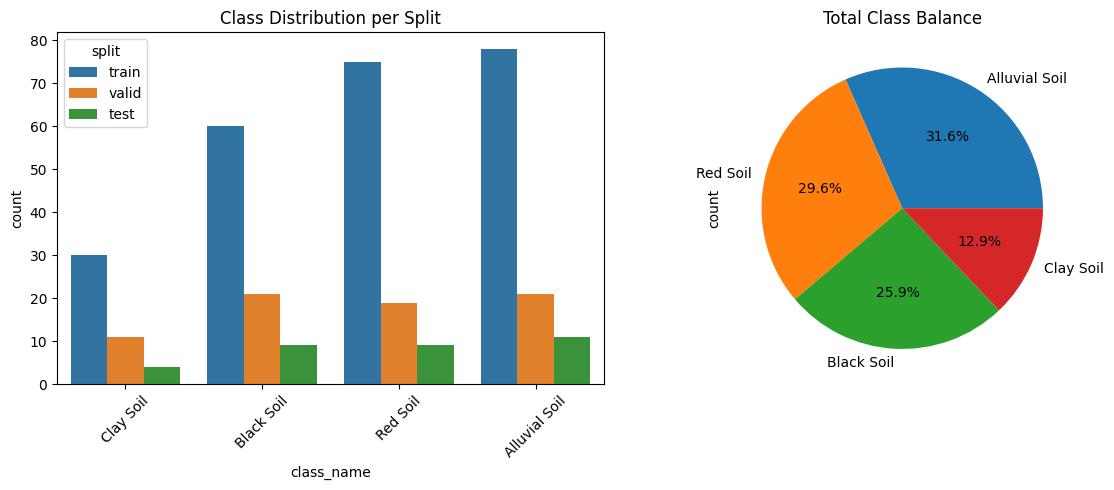

Total Annotations: 348


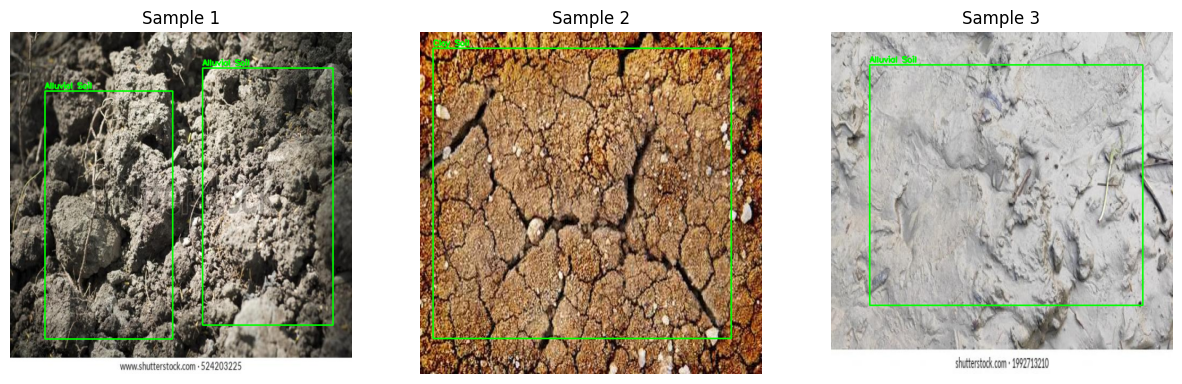

In [4]:
def parse_dataset_stats(data_dir):
    """Parses YOLO labels to extract class distribution."""
    stats = []
    class_map = {}

    # Load class names from YAML
    with open(os.path.join(data_dir, "data.yaml"), 'r') as f:
        data_config = yaml.safe_load(f)
        class_map = {i: name for i, name in enumerate(data_config['names'])}

    # Iterate through splits
    for split in ['train', 'valid', 'test']:
        labels_path = os.path.join(data_dir, split, 'labels')
        if not os.path.exists(labels_path): continue

        for label_file in os.listdir(labels_path):
            if not label_file.endswith('.txt'): continue

            with open(os.path.join(labels_path, label_file), 'r') as f:
                for line in f:
                    class_id = int(line.split()[0])
                    stats.append({
                        'split': split,
                        'class_id': class_id,
                        'class_name': class_map.get(class_id, "Unknown")
                    })
    return pd.DataFrame(stats), class_map

# 1. Calculate Statistics
df_stats, class_map = parse_dataset_stats(Config.DATASET_DIR)

# 2. Plot Distribution
if not df_stats.empty:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.countplot(data=df_stats, x='class_name', hue='split')
    plt.title("Class Distribution per Split")
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    df_stats['class_name'].value_counts().plot.pie(autopct='%1.1f%%')
    plt.title("Total Class Balance")

    plt.tight_layout()
    plt.show()

    print(f"Total Annotations: {len(df_stats)}")
else:
    print("No annotations found. Check dataset structure.")

# 3. Visual Data Inspection Function
def visualize_sample(image_path, label_path, class_map):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = list(map(float, line.strip().split()))
                cls_id = int(parts[0])
                x, y, bw, bh = parts[1], parts[2], parts[3], parts[4]

                # Denormalize coordinates
                l = int((x - bw / 2) * w)
                r = int((x + bw / 2) * w)
                t = int((y - bh / 2) * h)
                b = int((y + bh / 2) * h)

                cv2.rectangle(image, (l, t), (r, b), (0, 255, 0), 2)
                cv2.putText(image, class_map[cls_id], (l, t - 5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return image

# Display 3 random training samples
train_img_dir = os.path.join(Config.DATASET_DIR, "train", "images")
train_lbl_dir = os.path.join(Config.DATASET_DIR, "train", "labels")
sample_files = random.sample(os.listdir(train_img_dir), 3)

plt.figure(figsize=(15, 5))
for i, img_file in enumerate(sample_files):
    img_path = os.path.join(train_img_dir, img_file)
    lbl_path = os.path.join(train_lbl_dir, img_file.replace('.jpg', '.txt').replace('.png', '.txt'))

    annotated_img = visualize_sample(img_path, lbl_path, class_map)

    plt.subplot(1, 3, i + 1)
    plt.imshow(annotated_img)
    plt.axis('off')
    plt.title(f"Sample {i+1}")
plt.show()

In [5]:
# Initialize YOLO model (load pretrained weights)
model = YOLO(f"yolov8{Config.MODEL_SIZE}.pt")

print(f"Starting training on {DEVICE}...")

# Train the model
results = model.train(
    data=os.path.join(Config.DATASET_DIR, "data.yaml"),
    epochs=Config.EPOCHS,
    imgsz=Config.IMG_SIZE,
    batch=Config.BATCH_SIZE,
    device=DEVICE,
    optimizer=Config.OPTIMIZER,
    seed=Config.SEED,
    plots=True,           # Automatically generate training plots
    save=True,            # Save checkpoints
    val=True,             # Validate during training
    verbose=True
)

print("Training complete.")
print(f"Best model saved at: {results.save_dir}")

Starting training on 0...
Ultralytics 8.3.245 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Soil-detection-3/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, persp

In [6]:
from ultralytics import YOLO

model = YOLO("/content/runs/detect/train/weights/best.pt")
metrics = model.val()  # evaluate model


precision = metrics.results_dict['metrics/precision(B)']
recall = metrics.results_dict['metrics/recall(B)']
map50 = metrics.results_dict['metrics/mAP50(B)']
map5095 = metrics.results_dict['metrics/mAP50-95(B)']

# Calculate simple accuracy
accuracy = (precision + recall) / 2

# Print results
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("mAP50:", round(map50, 4))
print("mAP50-95:", round(map5095, 4))
print("Accuracy:", round(accuracy, 4))
print("Accuracy (%):", round(accuracy * 100, 2), "%")

Ultralytics 8.3.245 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1557.4±751.2 MB/s, size: 84.4 KB)
val: Scanning /content/Soil-detection-3/valid/labels.cache... 58 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 58/58 119.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 1.8it/s 2.2s
                   all         58         72      0.658      0.607      0.593      0.365
         Alluvial Soil         18         21      0.491      0.689      0.574      0.281
            Black Soil         17         21      0.904      0.901      0.874      0.536
             Clay Soil          9         11       0.79      0.364      0.468      0.326
              Red Soil         15         19      0.444      0.474      0.456      0.316
Speed: 11.0ms preprocess, 6.7ms inference, 0

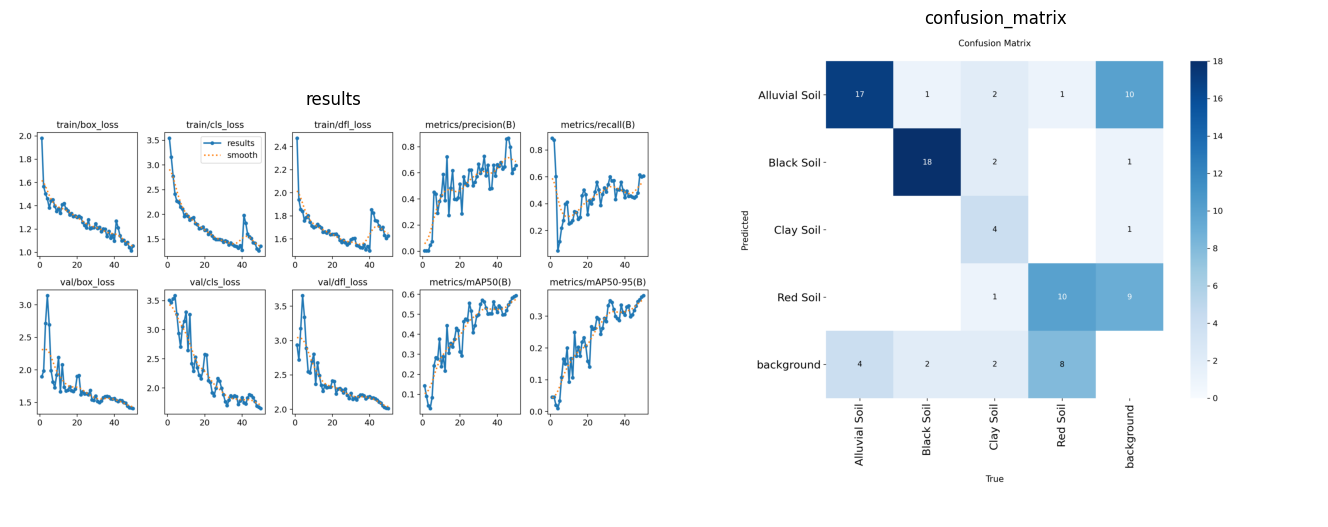

In [7]:
 results_dir = Path(results.save_dir)

# List generated plots
plots = [
    "results.png",
    "confusion_matrix.png",
    "F1_curve.png"
]

plt.figure(figsize=(20, 10))
for i, plot_name in enumerate(plots):
    plot_path = results_dir / plot_name
    if plot_path.exists():
        img = Image.open(plot_path)
        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(plot_name.replace('.png', ''))
    else:
        print(f"Warning: {plot_name} not found.")
plt.tight_layout()
plt.show()

In [8]:
# Load the best performing model
best_model_path = results_dir / "weights" / "best.pt"
best_model = YOLO(best_model_path)

print("Validating on Test Set...")
metrics = best_model.val(split='test')

print("\n" + "="*30)
print(f"Test mAP50: {metrics.box.map50:.3f}")
print(f"Test mAP50-95: {metrics.box.map:.3f}")
print(f"Precision: {metrics.box.mp:.3f}")
print(f"Recall: {metrics.box.mr:.3f}")
print("="*30 + "\n")

Validating on Test Set...
Ultralytics 8.3.245 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1534.0±290.2 MB/s, size: 74.7 KB)
val: Scanning /content/Soil-detection-3/test/labels... 28 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 28/28 2.2Kit/s 0.0s
val: New cache created: /content/Soil-detection-3/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 2.0it/s 1.0s
                   all         28         33      0.928      0.779      0.901      0.617
         Alluvial Soil          9         11      0.947      0.636      0.809      0.563
            Black Soil          8          9          1      0.814      0.961      0.568
             Clay Soil          4          4      0.987          1      0.995      0.846
              Red Soil          7          9    

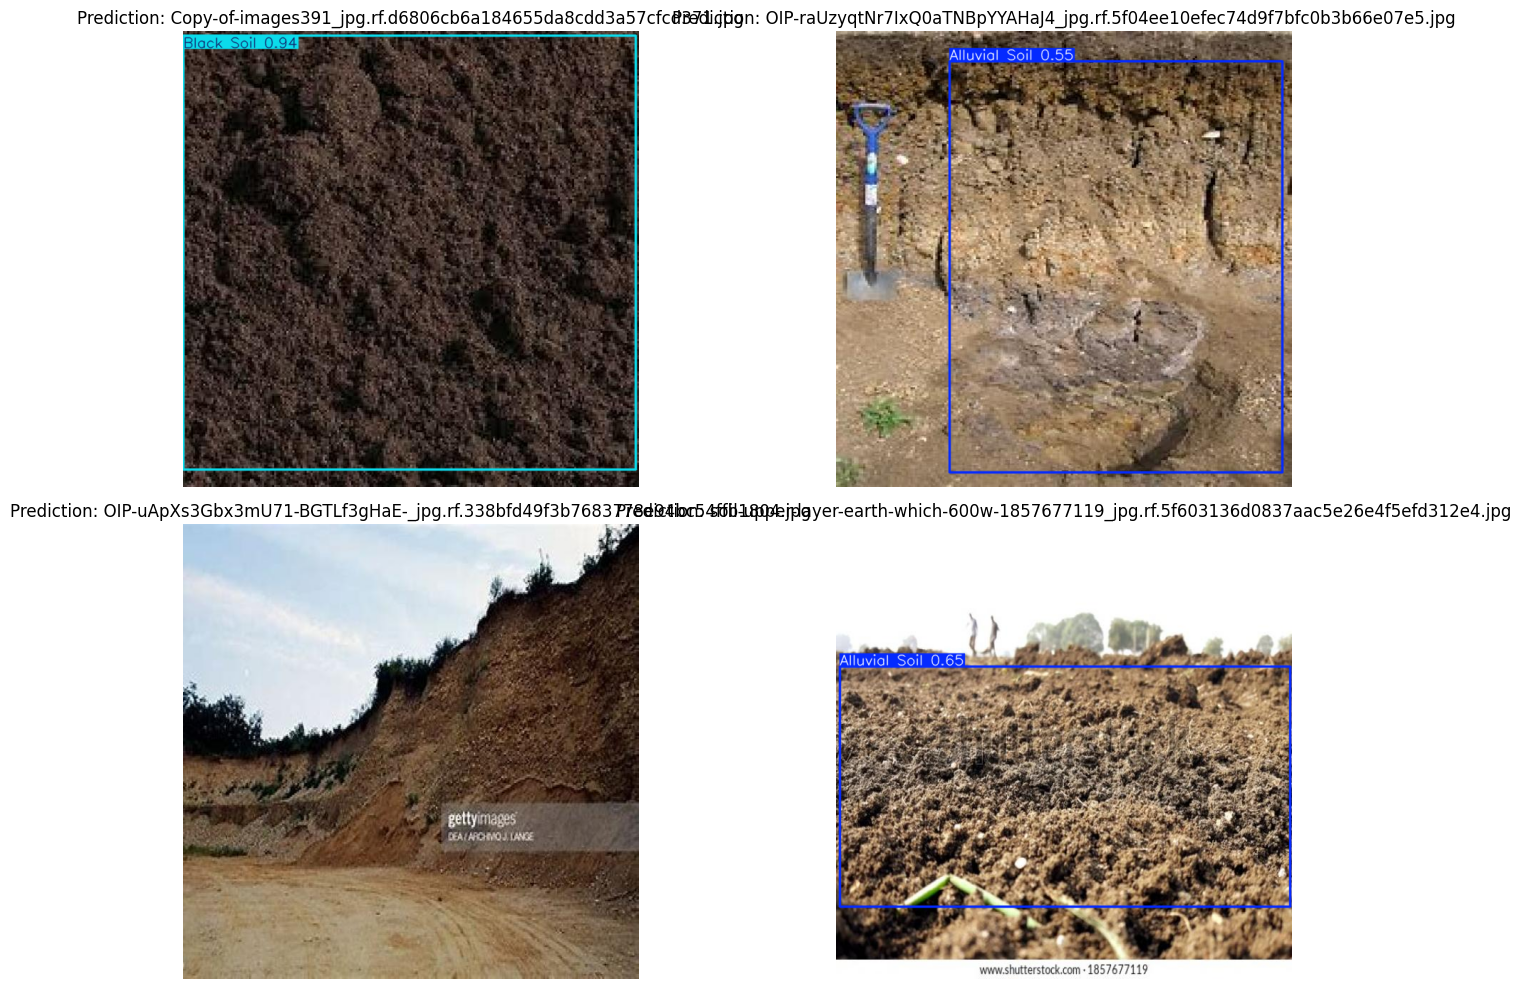

In [9]:
test_images_dir = os.path.join(Config.DATASET_DIR, "test", "images")
test_files = random.sample(os.listdir(test_images_dir), 4)

plt.figure(figsize=(15, 10))
for i, file_name in enumerate(test_files):
    img_path = os.path.join(test_images_dir, file_name)

    # Run inference
    results = best_model.predict(source=img_path, conf=0.25, verbose=False)

    # Plot
    res_plotted = results[0].plot()
    res_rgb = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 2, i + 1)
    plt.imshow(res_rgb)
    plt.axis('off')
    plt.title(f"Prediction: {file_name}")

plt.tight_layout()
plt.show()

In [10]:
print("Exporting model to ONNX format for deployment...")
success = best_model.export(format="onnx")

if success:
    print(f"Model exported successfully: {success}")
    # Code to download file if running in Colab
    try:
        from google.colab import files
        files.download(success)
    except ImportError:
        print("Exported file is located locally at:", success)

Exporting model to ONNX format for deployment...
Ultralytics 8.3.245 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<2.0.0', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 14 packages in 196ms
Prepared 6 packages in 4.56s
Installed 6 packages in 260ms
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx==1.20.0
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.81

requirements: AutoUpdate success ✅ 5.6s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.20.0 opset 22.

Exporting to ONNX opset version 22 is not supported. by 'torch.onnx.export()'. The highest opset version supported is 20. To use a newer opset version, consider 'torch.onnx.export(..., dynamo=True)'. 


ONNX: slimming with onnxslim 0.1.81...
ONNX: export success ✅ 8.3s, saved as '/content/runs/detect/train/weights/best.onnx' (11.7 MB)

Export complete (8.7s)
Results saved to /content/runs/detect/train/weights
Predict:         yolo predict task=detect model=/content/runs/detect/train/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=/content/runs/detect/train/weights/best.onnx imgsz=640 data=/content/Soil-detection-3/data.yaml  
Visualize:       https://netron.app
Model exported successfully: /content/runs/detect/train/weights/best.onnx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>